In [1]:
import glob
import re

INPUT_FOLDER = '../../../travelogues-corpus/17th_century/books'

def read_file(f):
  with open(f, 'r') as file:
    str = file.read()
    ascii_only = re.sub('[^A-Za-z0-9 ]+', '', str)
    return re.sub('\\s+', ' ', ascii_only)

# List names of all .txt files in the folder
filenames = [f for f in glob.glob(INPUT_FOLDER + '**/*.txt')]
documents = [ { 'filename': f, 'text': read_file(f) } for f in filenames ]

f'Loaded {len(documents)} documents'

'Loaded 204 documents'

In [2]:
import string
import gensim

texts_cleaned = [ d['text'].translate(str.maketrans('', '', string.punctuation)).lower() for d in documents ]
training_data = [ gensim.models.doc2vec.TaggedDocument(txt.split(), [ i ]) for i, txt in enumerate(texts_cleaned) ]

model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)
model.build_vocab(training_data)
model.train(training_data, total_examples=model.corpus_count, epochs=model.epochs)

In [18]:
from sklearn.cluster import KMeans
import numpy as np

vectors = [ model.docvecs[idx] for idx in range(0, len(documents)) ]

CLUSTER_NUM = 12

km = KMeans(
  n_clusters=CLUSTER_NUM, init='random',
  n_init=10, max_iter=300, 
  tol=1e-04, random_state=0)

km_10_clusters = km.fit_predict(vectors)

In [20]:
from sklearn.manifold import TSNE

tsne_model_2d = TSNE(perplexity=12, n_components=2, init='pca', n_iter=4000, random_state=32)
embeddings_2d = tsne_model_2d.fit_transform(np.array(vectors))

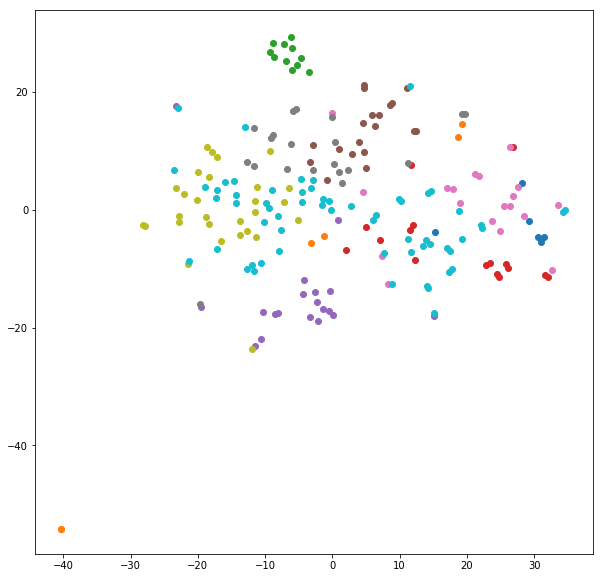

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.tab10(np.linspace(0, 1, CLUSTER_NUM))

clusters = [ embeddings_2d[km_10_clusters == idx] for idx in range(CLUSTER_NUM) ]
clusters = sorted(clusters, key=len)

fig = plt.figure(figsize=(10, 10))

for idx, c in enumerate(clusters):
  x = c[:, 0]
  y = c[:, 1]
  plt.scatter(x, y, s=36, color=colors[idx])

plt.show()

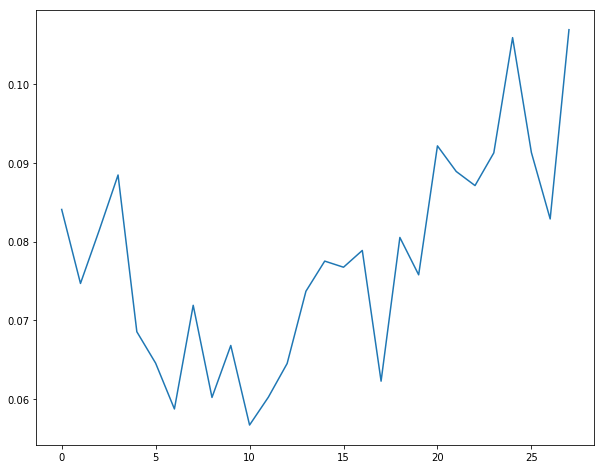

In [22]:
from sklearn.metrics import silhouette_score

sil = []
k_max = 30

for k in range(2, k_max):
  kmeans = KMeans(n_clusters = k).fit(vectors)
  labels = kmeans.labels_
  sil.append(silhouette_score(vectors, labels, metric = 'euclidean'))

plt.figure(figsize=(10, 8))
plt.plot(sil)
plt.show()

In [23]:
clustered_filenames = [ np.array(filenames)[km_10_clusters == idx] for idx in range(CLUSTER_NUM) ]

def to_barcode(filename):
  return filename[filename.rindex('/') + 1: -4]

clustered_urls = map(lambda cluster: [ f'http://data.onb.ac.at/ABO/+{to_barcode(f)}' for f in cluster ] , clustered_filenames)
list(clustered_urls)

[['http://data.onb.ac.at/ABO/+Z180059703',
  'http://data.onb.ac.at/ABO/+Z162737708',
  'http://data.onb.ac.at/ABO/+Z156319401',
  'http://data.onb.ac.at/ABO/+Z158022808',
  'http://data.onb.ac.at/ABO/+Z164724109',
  'http://data.onb.ac.at/ABO/+Z159574205',
  'http://data.onb.ac.at/ABO/+Z163301306',
  'http://data.onb.ac.at/ABO/+Z156935501',
  'http://data.onb.ac.at/ABO/+Z178361408',
  'http://data.onb.ac.at/ABO/+Z15248840X',
  'http://data.onb.ac.at/ABO/+Z180307607'],
 ['http://data.onb.ac.at/ABO/+Z220030607',
  'http://data.onb.ac.at/ABO/+Z255419501',
  'http://data.onb.ac.at/ABO/+Z257368909',
  'http://data.onb.ac.at/ABO/+Z257382001',
  'http://data.onb.ac.at/ABO/+Z260071701',
  'http://data.onb.ac.at/ABO/+Z27280208',
  'http://data.onb.ac.at/ABO/+Z260071609',
  'http://data.onb.ac.at/ABO/+Z221886406',
  'http://data.onb.ac.at/ABO/+Z255414503',
  'http://data.onb.ac.at/ABO/+Z258853601',
  'http://data.onb.ac.at/ABO/+Z164646202',
  'http://data.onb.ac.at/ABO/+Z252901907',
  'http://d